Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process.
Given the abstract and title for a set of research articles, predict the topics for each article included in the test set. 
Note that a research article can possibly have more than 1 topic. The research article abstracts and titles are sourced from the following 6 topics: 
1. Computer Science

2. Physics

3. Mathematics

4. Statistics

5. Quantitative Biology

6. Quantitative Finance

Submissions are evaluated on micro F1 Score between the predicted and observed topics for each article in the test set

In [1]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.4MB/s 


In [2]:
import warnings
from pprint import pprint
from time import time
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from skmultilearn.problem_transform import LabelPowerset
from tqdm import tqdm
from sklearn.metrics import f1_score, make_scorer

In [3]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across',
                'among','beside','however','yet','within'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
raw_data = pd.read_csv('train.csv')
raw_data.head(1)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0


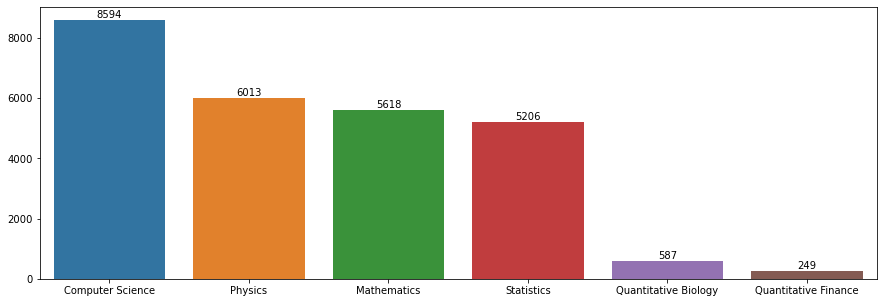

In [ ]:
#EDA: to check the composition of classes
data = raw_data.iloc[:,3:]
plt.figure(figsize=(15,5))
lables = data.sum().values
ax = sns.barplot(data.columns,lables)

rects = ax.patches
for rect,lable in zip(rects,lables):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2,height+5,lable,ha='center',va='bottom')


In [6]:
#preprocessing
data = raw_data.copy()

In [7]:
from sklearn.base import TransformerMixin, BaseEstimator
import nltk
from nltk.corpus import wordnet
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas

class preTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.re_stop_words = re.compile(r'\b(' + '|'.join(en_stop) + ')\\W', re.I)
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        pass
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        df['ABSTRACT'] = df['ABSTRACT'].apply(self.preprocess)
        df['TITLE'] = df['TITLE'].apply(self.preprocess)
    
    def getPosTagDef(self,postag):
        if postag in ['JJ', 'JJR', 'JJS']:
            return wordnet.ADJ
        elif postag in ['RB', 'RBR', 'RBS']:
            return wordnet.ADV
        elif postag in ['NN', 'NNS', 'NNP', 'NNPS']:
            return wordnet.NOUN
        elif postag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            return wordnet.VERB
        else:
            return None
    def preprocess(self,string):
        result=[]
        #clean
        string = re.sub('[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~\n]',' ',string)
        string = re.sub(r'[^a-zA-Z ]','',string)
        string = re.sub(r'\b\w{1,2}\b', '', string)
        #stop words
        string = self.re_stop_words.sub(' ',string)
        #stemming
        string = ' '.join([self.stemmer.stem(x.strip()) for x in string.split()])
        #lemmatize
        pos_tags = nltk.pos_tag(string.split())
        for token,postag in pos_tags:    
            pos = self.getPosTagDef(postag)
            if pos != None:
                  result.append(self.lemmatizer.lemmatize(token,pos))
            else:
                  result.append( self.lemmatizer.lemmatize(token))
        return ' '.join(result)


In [8]:
#preprocess pipeline
data = raw_data.copy()
pretr = preTransformer()
pretr.fit_transform(data)

In [ ]:
#model

X = data['ABSTRACT']
y = data.iloc[:,3:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


classifiers = [
    #BinaryRelevance(GaussianNB()),
    #ClassifierChain(LogisticRegression()),
    LabelPowerset(LogisticRegression()), #76
    #MLkNN(),
    #LabelPowerset(GaussianNB()) #56
]
check_params = {
    'vect__max_df': (0.5, 0.75, 1.0,2.0),
    'vect__max_features': (50,100,200,300),
    'vect__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2')
}
cvrange = range(4,6)
for classifier in classifiers:
    pipe = Pipeline([('vect',CountVectorizer()), ('tfidf', TfidfTransformer()),('model',classifier)])
    print(classifier)
    with tqdm(total=len(range(4,6))) as bar:
        for cv in tqdm(range(4,6)):
          Gsc = GridSearchCV(estimator=pipe,param_grid=check_params, cv=cv,scoring='f1_micro')
          Gsc.fit(X_train,y_train)
          print('score   : %3.2f' %(  Gsc.score(X_test,y_test)))
          print('best_params :', [(k,v) for (k,v) in Gsc.best_params_.items()])
          bar.update(1)


In [9]:
X = data['ABSTRACT']
y = data.iloc[:,3:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

classifiers = [
    #BinaryRelevance(GaussianNB()),
    #ClassifierChain(LogisticRegression()),
    LabelPowerset(LogisticRegression()), #76
    #MLkNN(),
    #LabelPowerset(GaussianNB()) #56
]
check_params = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'tfidf__max_df': (0.5, 0.75, 1.0,2.0),
    'tfidf__max_features': (50,100,200,300),
    'tfidf__ngram_range': ((1, 1), (1, 2),(1,3))  # unigrams or bigrams
}
cvrange = range(4,6)
for classifier in classifiers:
    pipe = Pipeline([('tfidf', TfidfVectorizer()),('model',classifier)])
    print(classifier)
    with tqdm(total=len(range(4,6))) as bar:
        for cv in tqdm(range(4,6)):
          Gsc = GridSearchCV(estimator=pipe,param_grid=check_params, cv=cv,scoring='f1_micro')
          Gsc.fit(X_train,y_train)
          print('score   : %3.2f' %(  Gsc.score(X_test,y_test)))
          print('best_params :', [(k,v) for (k,v) in Gsc.best_params_.items()])
          bar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

LabelPowerset(classifier=LogisticRegression(C=1.0, class_weight=None,
                                            dual=False, fit_intercept=True,
                                            intercept_scaling=1, l1_ratio=None,
                                            max_iter=100, multi_class='auto',
                                            n_jobs=None, penalty='l2',
                                            random_state=None, solver='lbfgs',
                                            tol=0.0001, verbose=0,
                                            warm_start=False),
              require_dense=[True, True])



  0%|          | 0/2 [1:20:56<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
X = data[['TITLE','ABSTRACT']]
def getTitle():
  return data['TITLE']

def getAbstract():
  return  data['ABSTRACT']

y = data.iloc[:,3:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

classifiers = [
    #BinaryRelevance(GaussianNB()),
    #ClassifierChain(LogisticRegression()),
    LabelPowerset(LogisticRegression()), #76
    #MLkNN(),
    #LabelPowerset(GaussianNB()) #56
]
check_params = {
    'pipe_title__tfidf__use_idf': (True, False),
    'pipe_title__tfidf__norm': ('l1', 'l2'),
    'pipe_title__tfidf__max_df': (0.5, 0.75, 1.0,2.0),
    'pipe_title__tfidf__max_features': (50,100,200,300),
    'pipe_title__tfidf__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams

    'pipe_abstract__tfidf__use_idf': (True, False),
    'pipe_abstract__tfidf__norm': ('l1', 'l2')
    'pipe_abstract__tfidf__max_df': (0.5, 0.75, 1.0,2.0),
    'pipe_abstract__tfidf__max_features': (50,100,200,300),
    'pipe_abstract__tfidf__ngram_range': ((1, 1), (1, 2),(1,3))  # unigrams or bigrams
}
cvrange = range(4,6)
pipe_title = Pipeline([('col_sel',FunctionTransformer(getTitle,validate=False) ), ('tfidf', TfidfVectorizer())])
pipe_abstract = Pipeline([('col_sel',FunctionTransformer(getAbstract,validate=False) ), ('tfidf', TfidfVectorizer())])

for classifier in classifiers:
    pipe = Pipeline([FeatureUnion([('pipe_title',pipe_title),('pipe_abstract',pipe_abstract)]),('model',classifier)])
    print(classifier)
    with tqdm(total=len(range(4,6))) as bar:
        for cv in tqdm(range(4,6)):
          Gsc = GridSearchCV(estimator=pipe,param_grid=check_params, cv=cv,scoring='f1_micro')
          Gsc.fit(X_train,y_train)
          print('score   : %3.2f' %(  Gsc.score(X_test,y_test)))
          print('best_params :', [(k,v) for (k,v) in Gsc.best_params_.items()])
          bar.update(1)

In [ ]:
from sklearn.metrics import f1_score
data = raw_data.copy()
pretr = preTransformer()
pretr.fit_transform(data)

X = data['ABSTRACT']
y = data.iloc[:,3:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = LabelPowerset(classifier=LogisticRegression(C=1.0, class_weight=None,
                                            dual=False, fit_intercept=True,
                                            intercept_scaling=1, l1_ratio=None,
                                            max_iter=100, multi_class='auto',
                                            n_jobs=None, penalty='l2',
                                            random_state=None, solver='lbfgs',
                                            tol=0.0001, verbose=0, warm_start=False))
pipe = Pipeline([('vect', CountVectorizer(max_df=0.5,max_features=300,ngram_range=(1,2))),('tfidf', TfidfTransformer(norm='l2',use_idf=True)),('model',model)])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print('Accuracy on test data: {:.1f}%'.format(f1_score(y_test, y_pred, average='micro')*100))

Accuracy on test data: 76.3%


In [ ]:
test_data = pd.read_csv('test.csv')
pretr.transform(test_data)

X_test_data = test_data['ABSTRACT']
y_test_data = pipe.predict(X_test_data)
y_test_data


<8989x6 sparse matrix of type '<class 'numpy.int64'>'
	with 10410 stored elements in List of Lists format>

In [ ]:
y_res = y_test_data.todense()
res = pd.DataFrame(columns=y.columns,data=y_res)
res.insert(0,'ID',test_data['ID'])
res.iloc[:,0:].to_csv('sample_submission.csv',index = False)

scipy.sparse.lil.lil_matrix